In [81]:
import os
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
DATA_DIR = os.path.join('..', 'data')

In [12]:
orders = pd.read_csv(os.path.join(DATA_DIR, 'orders.csv'))
orders = orders[['customer_id', 'LOCATION_NUMBER', 'vendor_id', 'deliverydistance']]

vendors = pd.read_csv(os.path.join(DATA_DIR, 'vendors.csv'))
vendors = vendors[['id', 'latitude', 'longitude', 'serving_distance']]

locs = pd.read_csv(os.path.join(DATA_DIR, 'train_locations.csv'))
locs = locs[['customer_id', 'location_number', 'latitude', 'longitude']]

C:\Users\1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
orders.head(3)

,customer_id,LOCATION_NUMBER,vendor_id,deliverydistance
0,92PEE24,0,105,0.0
1,QS68UD8,0,294,0.0
2,MB7VY5F,0,83,0.0


In [14]:
vendors.head(3)

,id,latitude,longitude,serving_distance
0,4,-0.588596,0.754434,6.0
1,13,-0.471654,0.744470,5.0
2,20,-0.407527,0.643681,8.0


In [15]:
locs.head(3)

,customer_id,location_number,latitude,longitude
0,02SFNJH,0,1.682392,-78.789737
1,02SFNJH,1,1.679137,0.766823
2,02SFNJH,2,-0.498648,0.661241


In [20]:
f"Ratio of orders with non-zero distance: {len(orders[orders.deliverydistance != 0]) / len(orders)}"

'Ratio of orders with non-zero distance: 0.5889743760300954'

In [21]:
orders = orders[orders.deliverydistance != 0]

In [46]:
len(orders)

79690

In [23]:
set(orders.customer_id) - set(locs.customer_id)

set()

In [43]:
df = pd.merge(orders, locs,  how='inner', left_on=['customer_id','LOCATION_NUMBER'], right_on = ['customer_id','location_number'])

In [44]:
df.columns = ['cust_id', 'loc_num', 'vendor_id', 'deliverydistance', 'location_number', 'lat_cust', 'long_cust']
del df['location_number']
df.head(3)

,cust_id,loc_num,vendor_id,deliverydistance,lat_cust,long_cust
0,BCNOR7E,0,201,1.68,0.120613,0.543505
1,2JJAO46,2,20,3.87,-0.071489,0.634343
2,2JJAO46,2,20,3.87,-0.071489,0.634343


In [45]:
len(df)

79690

In [47]:
df = pd.merge(df, vendors, how='inner', left_on='vendor_id', right_on='id')

In [48]:
len(df)

79690

In [54]:
df = df[['deliverydistance', 'lat_cust', 'long_cust', 'latitude', 'longitude', 'serving_distance']]
df.columns = ['deliv_dist', 'lat_cust', 'long_cust', 'lat_rest', 'long_rest', 'serv_dist']
df.head(15)

,deliv_dist,lat_cust,long_cust,lat_rest,long_rest,serv_dist
0,1.68,0.120613,0.543505,0.015623,0.531628,15.0
1,13.62,-0.822444,0.749720,0.015623,0.531628,15.0
2,2.61,0.039638,0.580358,0.015623,0.531628,15.0
3,6.91,0.290948,0.418965,0.015623,0.531628,15.0
4,6.91,0.290948,0.418965,0.015623,0.531628,15.0
5,14.40,-0.721908,0.787174,0.015623,0.531628,15.0
6,14.40,-0.721908,0.787174,0.015623,0.531628,15.0
7,8.34,0.609002,0.434737,0.015623,0.531628,15.0
8,12.41,0.294405,0.289774,0.015623,0.531628,15.0
9,2.61,0.076112,0.572709,0.015623,0.531628,15.0


In [58]:
df['serv_m_deliv'] = df.serv_dist - df.deliv_dist

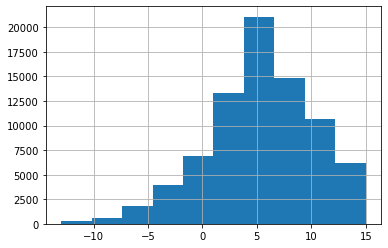

In [60]:
df.serv_m_deliv.hist()

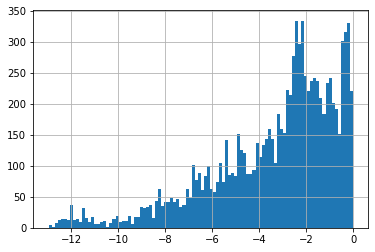

In [73]:
df[df.serv_m_deliv < 0]['serv_m_deliv'].hist(bins=100)

In [68]:
f"Ratio of orders that exeeded delivery distance: {sum(df.serv_m_deliv < 0) / len(df.serv_m_deliv)}"

'Ratio of orders that exeeded delivery distance: 0.12396787551763082'

In [77]:
f"Ratio of orders that exeeded delivery distance: {sum(df.serv_m_deliv < -4) / len(df.serv_m_deliv)}"

'Ratio of orders that exeeded delivery distance: 0.03964110929853181'

In [74]:
# For naive modeling can make cutoff: restaurant serving distance <= delivery distance + 4km 

### Estimating delivery distance with coords

In [124]:
#Euclidean - not working at all
# df['deliv_dist_estimation'] = np.sqrt(np.power(df['lat_cust'] - df['lat_rest'], 2) + 
#                                       np.power(df['long_cust'] - df['long_rest'], 2))

# Manhattan - not working 
df['deliv_dist_estimation'] = np.sqrt(np.abs(df['lat_cust'] - df['lat_rest']) + 
                                      np.abs(df['long_cust'] - df['long_rest']))

# Haversine - not working at all
# https://zindi.africa/competitions/akeed-restaurant-recommendation-challenge/discussions/1423
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
# df['deliv_dist_estimation'] = 2 * np.arcsin(np.sqrt(np.power(np.sin((df.lat_cust - df.long_cust) / 2), 2) + 
#                                                     np.power(np.sin((df.lat_rest - df.long_rest) / 2), 2) * 
#                                                     np.cos(df.lat_cust) * 
#                                                     np.cos(df.long_cust)))

df.head()

,deliv_dist,lat_cust,long_cust,lat_rest,long_rest,serv_dist,serv_m_deliv,deliv_dist_estimation,deliv_dist_estimation_coef
0,1.68,0.120613,0.543505,0.015623,0.531628,15.0,13.32,0.341858,2.619381
1,13.62,-0.822444,0.749720,0.015623,0.531628,15.0,1.38,1.027696,8.319830
2,2.61,0.039638,0.580358,0.015623,0.531628,15.0,12.39,0.269712,3.600303
3,6.91,0.290948,0.418965,0.015623,0.531628,15.0,8.09,0.622887,13.836851
4,6.91,0.290948,0.418965,0.015623,0.531628,15.0,8.09,0.622887,13.836851


In [125]:
df['deliv_dist_estimation_coef'] = df['deliv_dist'] / df['deliv_dist_estimation']
df.head()

,deliv_dist,lat_cust,long_cust,lat_rest,long_rest,serv_dist,serv_m_deliv,deliv_dist_estimation,deliv_dist_estimation_coef
0,1.68,0.120613,0.543505,0.015623,0.531628,15.0,13.32,0.341858,4.914324
1,13.62,-0.822444,0.749720,0.015623,0.531628,15.0,1.38,1.027696,13.252948
2,2.61,0.039638,0.580358,0.015623,0.531628,15.0,12.39,0.269712,9.677001
3,6.91,0.290948,0.418965,0.015623,0.531628,15.0,8.09,0.622887,11.093498
4,6.91,0.290948,0.418965,0.015623,0.531628,15.0,8.09,0.622887,11.093498


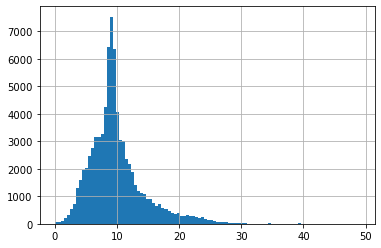

In [126]:
df[df.deliv_dist_estimation_coef < 50]['deliv_dist_estimation_coef'].hist(bins = 100)

In [127]:
sum(df.deliv_dist_estimation_coef > 50)

34

In [128]:
# Can use upper-bound of Manhattan distance